# Import Libraries

In [1]:
# For metadata/feature processing
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

# For neural network
import tensorflow as tf

# For Accuracy metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# For image
import cv2
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Meta Data
Not all dataset comes with prepared **metadata** (csv file containing file/image/feature/label info). Thus we need to learn how to prepare one for a custom dataset.

## Get Image Paths
First we'll use `glob` to access the file paths of each image to link them to their labels and data split.



In [2]:
paths = glob('/kaggle/input/mldl-i-assignment-02/train/*/*png')
print(f"Num Train: {len(paths)}")

test_paths = glob('/kaggle/input/mldl-i-assignment-02/test/*png')
print(f"Num Test: {len(test_paths)}")

Num Train: 50000
Num Test: 10000


## Build DataFrame (CSV File)

In [3]:
print('Train:')
df = pd.DataFrame(paths, columns=['image_path'])
display(df.head(2))

print('Test:')
test_df = pd.DataFrame(test_paths, columns=['image_path'])
display(test_df.head(2))

Train:


,image_path
0,/kaggle/input/mldl-i-assignment-02/train/airpl...
1,/kaggle/input/mldl-i-assignment-02/train/airpl...


Test:


,image_path
0,/kaggle/input/mldl-i-assignment-02/test/01301.png
1,/kaggle/input/mldl-i-assignment-02/test/02578.png


# Sample from Data
To reduce time we've down sampled the data. If you are welcome to run on the full dataset. To do so, simply comment out the cell.

In [4]:
df = df.sample(25000, random_state=42)
# test_df = test_df.sample(2000, random_state=42)

# Retreive Metadata
In the following cell we'll retreive `train-test` split and `class` infomation from **image path**. 


In [5]:
## CODE HINT
# Here is an example of the splitting
print("Sample Image Path :",df.image_path[0])
print("Splitting the Image Path by / :",df.image_path[0].split('/'))
print('Is it training or test split? : ',df.image_path[0].split('/')[-3])
print('What is the class name ? : ',df.image_path[0].split('/')[-2])
print('What is the image id ? : ',df.image_path[0].split('/')[-1])

Sample Image Path : /kaggle/input/mldl-i-assignment-02/train/airplane/0566.png
Splitting the Image Path by / : ['', 'kaggle', 'input', 'mldl-i-assignment-02', 'train', 'airplane', '0566.png']
Is it training or test split? :  train
What is the class name ? :  airplane
What is the image id ? :  0566.png


In [6]:
# First we map the class name from the image paths, similar to how it is done in the above code
# Train
df['class_name'] = df.image_path.map(lambda x: x.split('/')[-2]) # extract class

print("After mapping, we got the class name column in the dataframe:")
display(df.head(2))

After mapping, we got the class name column in the dataframe:


,image_path,class_name
33553,/kaggle/input/mldl-i-assignment-02/train/bird/...,bird
9427,/kaggle/input/mldl-i-assignment-02/train/horse...,horse


In [7]:
## Similarly, we get the split
df['split'] = df.image_path.map(lambda x: x.split('/')[-3]) # extract data split
display(df.head(2))

# Test
# test_df['class_label'] = test_df.image_path.map(lambda x: int(x.split('/')[-2]))  # extract class
test_df['split'] = test_df.image_path.map(lambda x: x.split('/')[-2])  # extract data split

display(test_df.head(2))

,image_path,class_name,split
33553,/kaggle/input/mldl-i-assignment-02/train/bird/...,bird,train
9427,/kaggle/input/mldl-i-assignment-02/train/horse...,horse,train


,image_path,split
0,/kaggle/input/mldl-i-assignment-02/test/01301.png,test
1,/kaggle/input/mldl-i-assignment-02/test/02578.png,test


In [8]:
name2label = {k: v for v, k in enumerate(sorted(df['class_name'].unique()))}
name2label

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [9]:
label2name = {v: k for k, v in name2label.items()}
label2name

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Now we map the class_labels to the number

In [10]:
# transforming the labels
df['class_label'] = df['class_name'].map(name2label)
display(df.head(2))

,image_path,class_name,split,class_label
33553,/kaggle/input/mldl-i-assignment-02/train/bird/...,bird,train,2
9427,/kaggle/input/mldl-i-assignment-02/train/horse...,horse,train,7


## Retreiver `id` column

In [11]:
df['id'] = df.image_path.map(lambda x: x.split('/')[-1]) # extract id
display(df.head(2))


test_df['id'] = test_df.image_path.map(lambda x: x.split('/')[-1]) # extract id
display(test_df.head(2))

,image_path,class_name,split,class_label,id
33553,/kaggle/input/mldl-i-assignment-02/train/bird/...,bird,train,2,0347.png
9427,/kaggle/input/mldl-i-assignment-02/train/horse...,horse,train,7,4224.png


,image_path,split,id
0,/kaggle/input/mldl-i-assignment-02/test/01301.png,test,01301.png
1,/kaggle/input/mldl-i-assignment-02/test/02578.png,test,02578.png


# Data Split

We create the train and validation split by using the `train_test_split` library from `skleaarn.model_selection`

In this case, we kept the validation data size 30% of the total data

In [12]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.3, random_state=42)
print(f"Train: {len(train_df)}")
print(f"Valid: {len(valid_df)}")

Train: 17500
Valid: 7500


# Data Validation

Before diving deeper into the analysis, it's crucial to ensure that our metadata – including path and label – aligns accurately with the actual data. Any discrepancies may lead to inaccurate results, undermining the integrity of our findings.


## Utility

In [13]:
# opencv (cv2) is used for loading image
def load_image(path):
    img = cv2.imread(path, -1) # `-1` means load image as it is, thus no gray to rgb conversion
    img = img[...,::-1] # bgr to rgb
    return img

## One Sample

## Image Shape: (32, 32, 3)
## Label: 2
## Name: bird


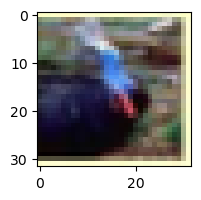

In [14]:
row = train_df.iloc[20]
img = load_image(row.image_path)
print(f"## Image Shape: {img.shape}")
print(f"## Label: {row.class_label}")
print(f'## Name: {row.class_name}')

plt.figure(figsize=(2,2))
plt.imshow(img);

## Multiple Samples

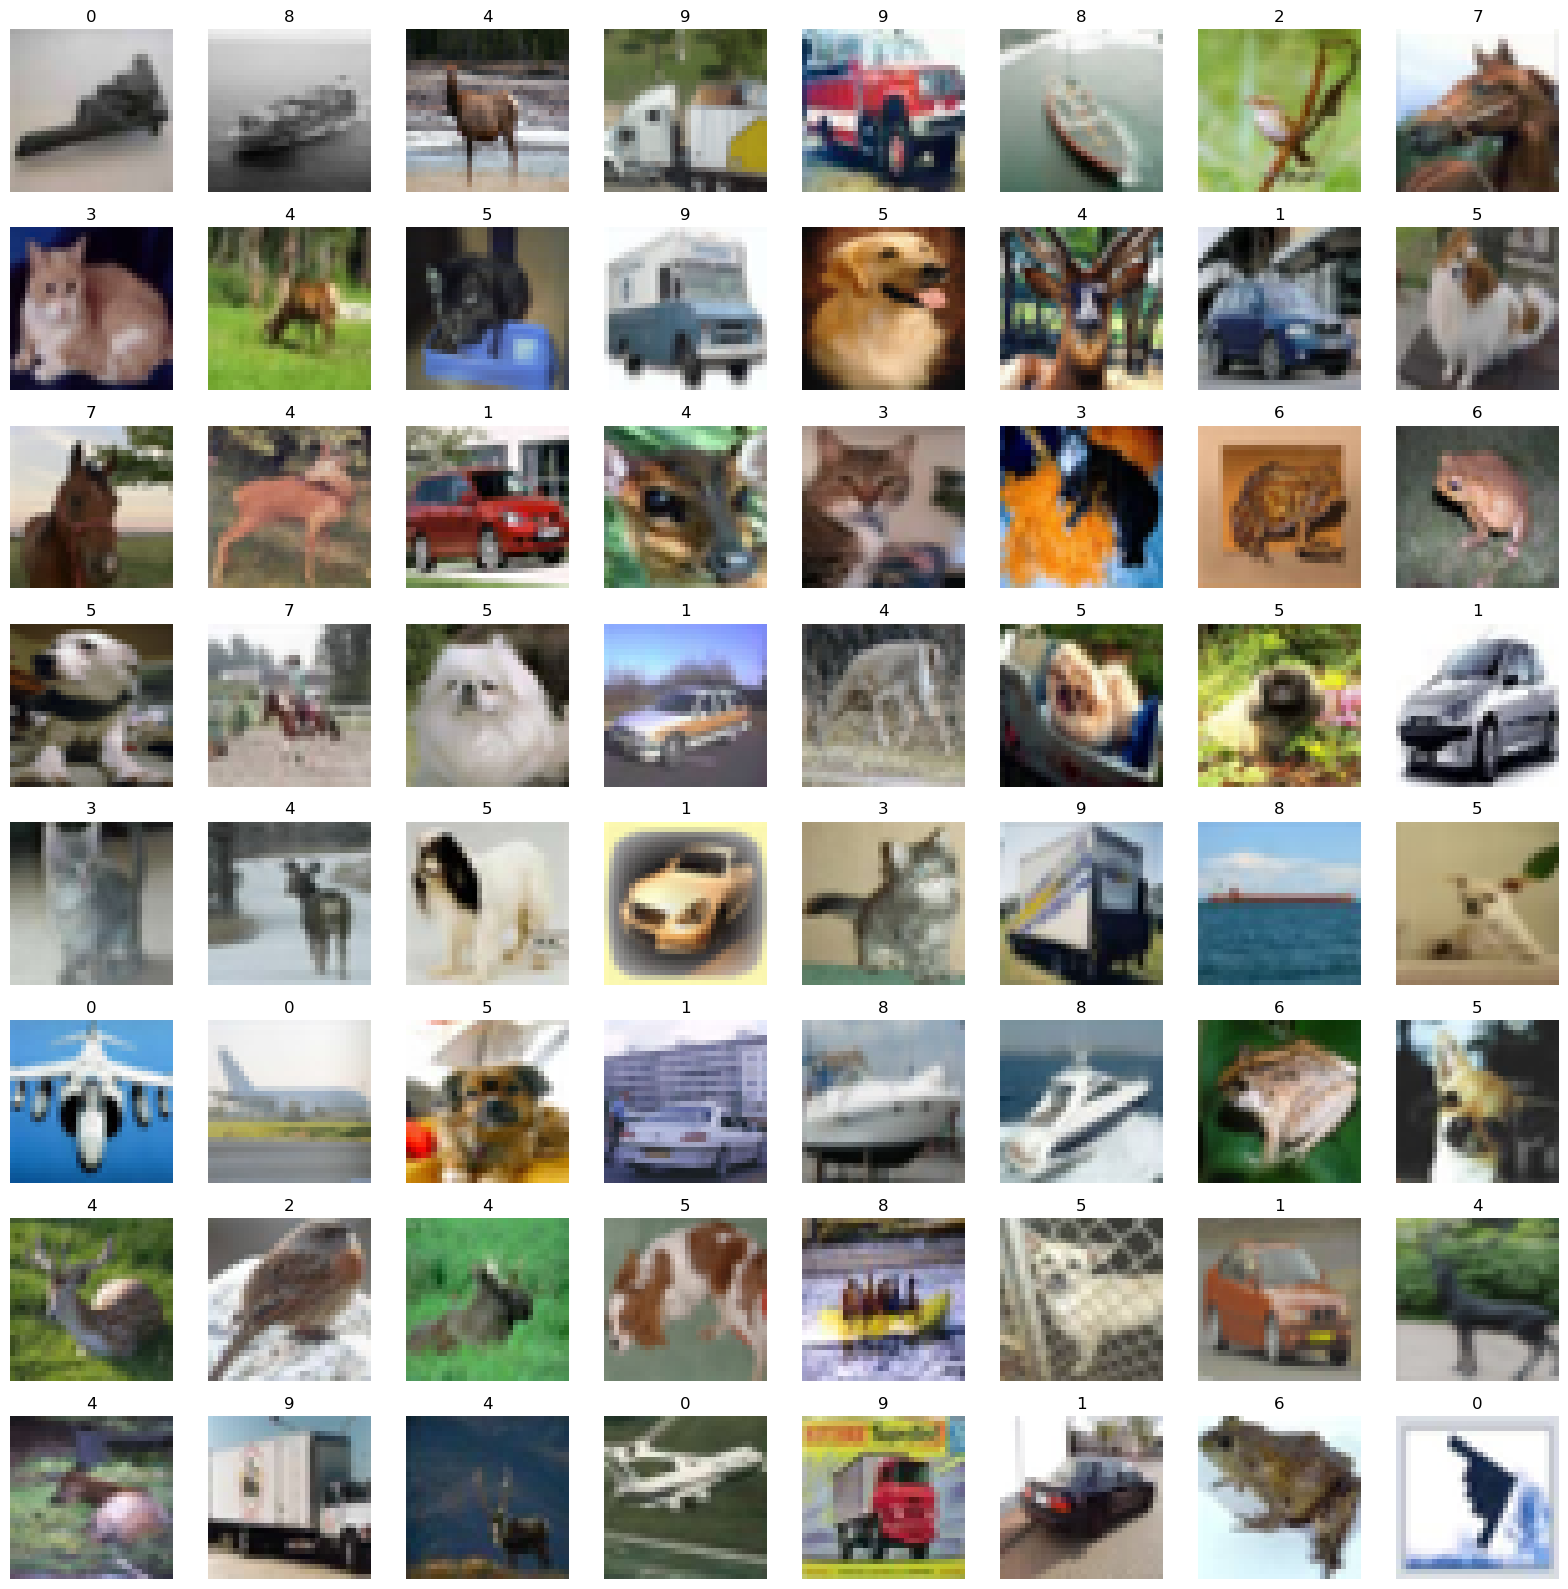

In [15]:
# Define the size of the grid
grid_size = 8

# Create a figure and axes for the grid of images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))

# Iterate over the images and labels
for i in range(grid_size**2):
    # Generate random index
    img_idx = np.random.randint(0, len(train_df))
    row = train_df.iloc[img_idx]
    
    # Load the image using your preferred method (not implemented here)
    img = load_image(row.image_path)

    # Determine the row and column indices in the grid
    x = i // grid_size
    y = i % grid_size

    # Display the image in the corresponding grid cell
    axes[x, y].imshow(img)
    axes[x, y].set_title(str(row.class_label))
    axes[x, y].axis('off')

# Adjust the spacing and layout of the subplots
plt.tight_layout()

# Show the grid of images
plt.show()

# Data Loader
Processing large datasets that consume a significant amount of memory can be challenging. Thus loading full data on memory is not feasible. Thus our previously used code format like this is not useful,

```python
X, y = np.load('some_training_set_with_labels.npy')

# Build model
model = LinearRegression()

# Train model on dataset, where all the data is loaded on memory at once
model.fit(x=X, y=y)
```
Moreover, traditional methods may not have enough memory to handle the data effectively. In such cases, batching, which involves dividing the dataset into smaller subsets or batches, can be employed to process the data efficiently. By generating and batching datasets using multiple cores in real-time, it becomes possible to seamlessly integrate them with deep learning models.

This dataloader can also handle the cases when label is not available (the test dataset where the images are available but there is no label). This makes it suitable for both training and testing.

The two cases (`label is not None` and `label is None`) are handled within the Dataloader code using `if` condition.

To be more specific, handling the `label is not None` case and keeping the `label is None` as the default case is adequate here

In [16]:
class DataLoader(tf.keras.utils.Sequence):
    """
    Custom data loader for Keras model training.
    Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

    Args:
        paths (list): List of file paths for the images.
        labels (list): List of corresponding labels for the images. 
                       Set labels= None if you are infering on test dataset (where you dont have labels)
        batch_size (int): Number of samples per batch.
        num_classes (int): Number of classes in the dataset.
        dim (tuple): Dimensions of the input images.
        shuffle (bool): Whether to shuffle the data after each epoch.

    Methods:
        __len__(): Returns the number of batches per epoch.
        __getitem__(index): Generates one batch of data.
        on_epoch_end(): Updates indexes after each epoch.
        __data_generation(batch_indexes): Generates data for a batch.
    """

    def __init__(self, paths, labels=None, batch_size=32, num_classes=10,
                 dim=(32, 32), shuffle=True):
        """Initialization method for the DataLoader class."""
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        batch = self.__data_generation(batch_indexes)

        return batch

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        """Generates data containing batch_size samples."""
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        if self.labels is not None:
            y = np.empty((self.batch_size), dtype=np.float32)

        # Generate data
        for i, idx in enumerate(batch_indexes):
            # Store sample
            X[i,] = load_image(self.paths[idx])

            # Store class
            if self.labels is not None:
                y[i] = self.labels[idx]

        # Flatten the image pixels for Dense layer
#         X = X.reshape(self.batch_size, -1)  # shape: (32, 28, 28) => (32, 28*28) => (32, 784)

        # Do scaling, range: [0, 255] => [0, 1]
        X = X / 255.0

        # Apply one-hot encoding to labels [0, 1, 2] => [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
        if self.labels is not None:
            y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
            return X, y
        
        # if there is labels = None, then only return X
        return X

## Loader check

In [17]:
paths = train_df.image_path.tolist()
labels = train_df.class_label.tolist()

train_loader = DataLoader(paths, labels, batch_size=16)

imgs, tars = train_loader.__getitem__(0)
print("Images:\n", imgs.shape)

print("\nLabels:\n", tars.shape)

Images:
 (16, 32, 32, 3)

Labels:
 (16, 10)


In [18]:
imgs.shape, tars.shape

((16, 32, 32, 3), (16, 10))

## Visualize Loader

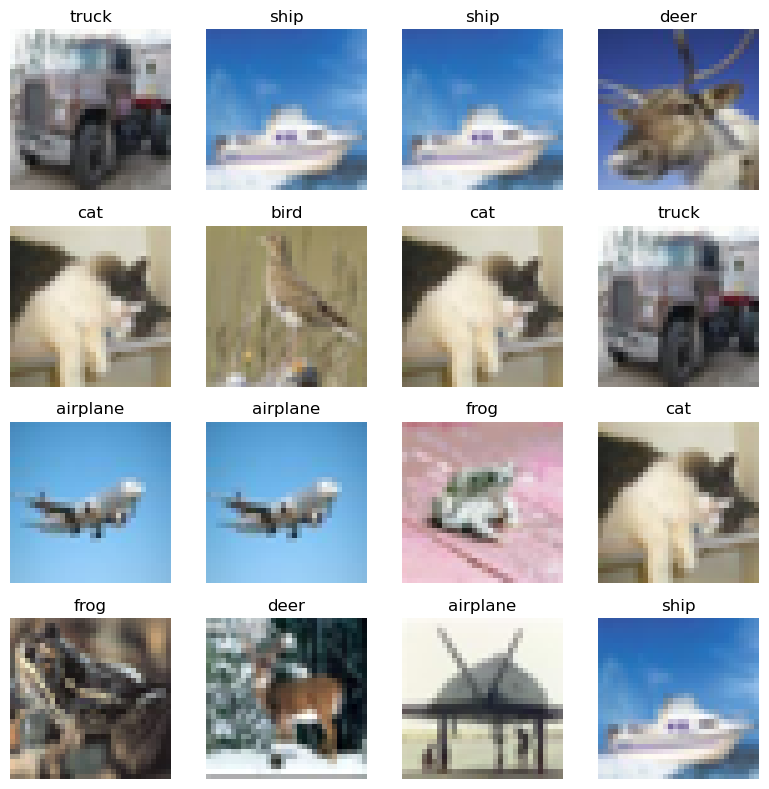

In [19]:
# Define the size of the grid
grid_size = 4

# Create a figure and axes for the grid of images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))

# Iterate over the images and labels
for i in range(16):
    # Generate random index
    img_idx = np.random.randint(0, 16)
    
    # Load the image
    img = imgs[img_idx].reshape(32, 32, 3) # images are feed as flatten to models
    
    # Get Label
    tar = tars[img_idx].argmax(axis=-1) # label is one hot encoded
    name = label2name[tar]

    # Determine the row and column indices in the grid
    x = i // grid_size
    y = i % grid_size

    # Display the image in the corresponding grid cell
    axes[x, y].imshow(img)
    axes[x, y].set_title(name)
    axes[x, y].axis('off')

# Adjust the spacing and layout of the subplots
plt.tight_layout()

# Show the grid of images
plt.show()

# Understanding Convolution in Signal Processing

Did you study **Discrete Convolution** in your `Digital Signal Processing (DSP)` course? Let's jog your memory!

Convolution is a mathematical operation that's a special way to combine two signals to form a third signal. It is the single most important technique in Digital Signal Processing. 

In the discrete domain, the convolution of two signals is defined as:

$$
y[n]=\sum_{k=-\infty}^{\infty} x[k] h[n-k]
$$

Here:
- $y[n]$ is the output signal
- $x[k]$ is the input signal
- $h[n-k]$ is the impulse response


Here is animation of convolution to make your memory more vivid.
<div style="text-align: center;">
  <img src="https://quincyaflint.weebly.com/uploads/2/6/5/0/26500868/convolution-1-fast_orig.gif" alt="Convolution Animation">
  <br>
  <em>Convolution in action.</em>
</div>


Interestingly, Convolution in Neural Networks (specifically in Convolutional Neural Networks, CNNs) has a very similar mechanism. The similarities include:

1. **Sliding Window**: This involves moving the filter/kernel over the input data.
2. **Multiplication of Signals**: Each element of the filter is multiplied with the corresponding element from the input.
3. **Addition of Values**: The multiplication results are then added together to form a single output pixel.

> **Note**: Unlike in digital signal processing, we **do not flip** any signal before convolving in neural networks. This is a key difference to remember!



# 1D Convolution

Convolution in deep learning for a 1D signal involves sliding a `filter/kernel` over the input signal, performing element-wise multiplications and summations to generate an output feature map. This operation helps capture local patterns and extract relevant information from the input signal. The filters used in convolution are learned through gradient descent thus they are referred as  `weights` which are learned iteratively by optimization. Mathematically convolution for 1D can be expressed as follows,

$$
\begin{aligned}
y_i &= \sum_j (W[j] \cdot x [i: (i+k)][j]) + B \\
&= \sum_j (W[j] \cdot x_i[j]) + B \\
&= \sum_j (W_j \cdot x_{ij}) + B
\end{aligned}
$$

It kinda looks like our very own **Linear/MLP** layer: $y = (\sum_{i} W_i \cdot x_i) + B$ doesn't it 🥳???.

For all signal components, we have $y = [y_0, y_1, ....., y_N] = [y_i]$.

Here, $W$ doesn't depend on $i$, implying it's consistent for any $i$, as seen in the animation below. This is known as 'Parameter Sharing' in CNNs, where we share the Kernel/Weights parameters for all inputs.

![1D Convolution Animation](https://e2eml.school/images/conv1d/stride_2.gif)
<center><em>1D convolution demonstration.</em></center>

> **Note**: Convolution in neural networks closely resembles that in signal processing, barring a few key differences such as not flipping the kernel.

> **Remember**: CNNs also incorporate features like stride, padding, and dilation. These features will be explored further in 2D convolution.

## Denoising (Moving Average)

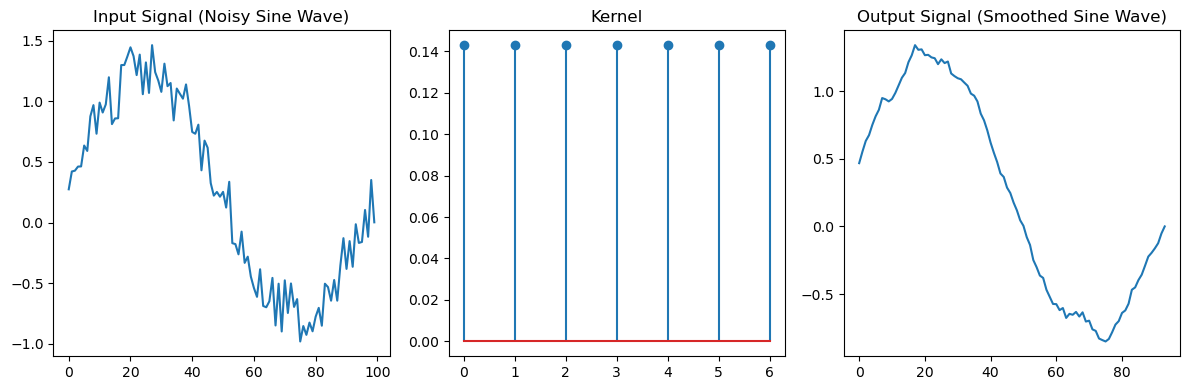

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def convolve_1d(input_signal, kernel, bias=0):
    output_signal = np.zeros(input_signal.size - kernel.size + 1)
    for i in range(output_signal.size):
        output_signal[i] = np.sum(input_signal[i:i+kernel.size] * kernel) + bias
    return output_signal

# Create a noisy sin wave as input signal
np.random.seed(0)
x = np.linspace(0, 2*np.pi, 100)
input_signal = np.sin(x) + 0.5 * np.random.rand(100)

# Define a smoothing kernel
kernel_size = 7
kernel = np.ones(kernel_size) / kernel_size

# Define a bias
bias = 0

# Perform convolution
output_signal = convolve_1d(input_signal, kernel, bias)

# Plot the input signal, kernel, and output signal
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(input_signal)
plt.title("Input Signal (Noisy Sine Wave)")

plt.subplot(1, 3, 2)
plt.stem(kernel)
plt.title("Kernel")

plt.subplot(1, 3, 3)
plt.plot(output_signal)
plt.title("Output Signal (Smoothed Sine Wave)")

plt.tight_layout()
plt.show()


## Edge Detection

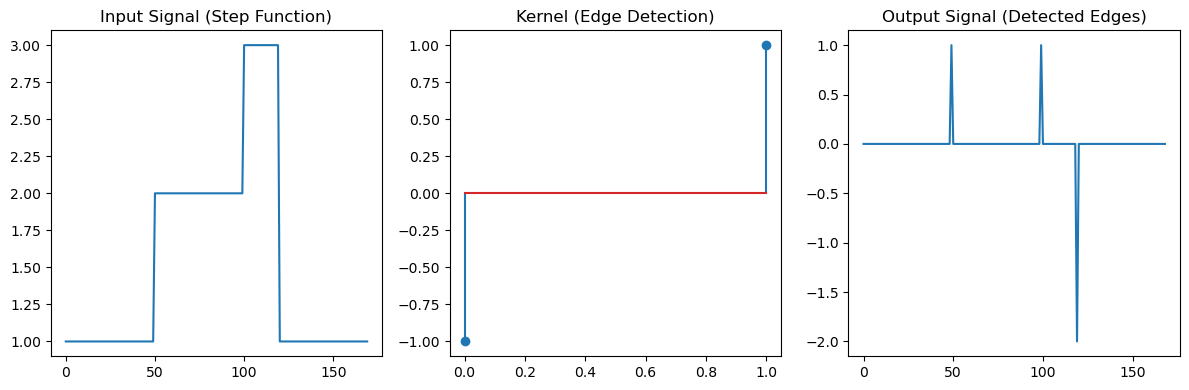

In [21]:
# Create a signal that suddenly jumps from 1 to 2
input_signal = np.ones(50)
input_signal = np.concatenate([input_signal, np.ones(50) + 1, np.ones(20)*3, np.ones(50)])

# Define an edge detection kernel
kernel = np.array([-1, 1])

# Define bias
bias = 0

# Perform convolution
output_signal = convolve_1d(input_signal, kernel, bias)

# Plot the input signal, kernel, and output signal
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(input_signal)
plt.title("Input Signal (Step Function)")

plt.subplot(1, 3, 2)
plt.stem(kernel)
plt.title("Kernel (Edge Detection)")

plt.subplot(1, 3, 3)
plt.plot(output_signal)
plt.title("Output Signal (Detected Edges)")

plt.tight_layout()
plt.show()


# 2D Convolution
<img src="https://miro.medium.com/v2/resize:fit:1086/0*zADmyHH92LZPdnmj.gif" width="500">


The output spatial dimension of a Convolutional Neural Network (CNN) can be calculated using the following formula:

$$
\begin{align}
L_o &= \left[ \frac{{L_i - R \cdot (K - 1) - 1 + 2P}}{S} \right] + 1\\
    &= \left[ \frac{{L_i - K' + 2P}}{S} \right] + 1
\end{align}
$$

Where:

- $L_o$ (Output size): This is the size (length/width) of the result after your input image is processed by the convolutional layer. Think of it as the size of your "output image" after applying the CNN layer.
- $L_i$ (Input size): This is the size (length/width) of the image you're inputting into the convolutional layer. It's the starting "picture size".
- $K$ (Kernel size): The kernel is like a small window you slide over the image. The kernel size is the size of this window. It determines how much of the image you look at each time.
- $R$ (Dilation rate): Like reading every 2nd, 3rd, etc. word in a sentence. It's how many cells (pixels) you skip over in the input when applying the kernel. This allows the CNN to consider a wider area using fewer parameters.
- $K'$ (Effective kernel size): This is the size of the kernel after considering the dilation rate. If the dilation rate is more than 1, your effective kernel size will be larger than your actual kernel size. $K' = R \cdot (K - 1) + 1$;  When $R=1$, then $K' = K$.
- $P$ (Padding): Padding is like adding a border of zeros around your image. This can help you maintain the image size after the convolution operation, or prevent the image from shrinking too much.
- $S$ (Stride): Stride is how much you move your kernel window each time. If it's 1, you move the window one pixel at a time. If it's 2, you skip a pixel each time you move the window.


## Brain Storm 🧠

**Why Padding is used in convolutional neural networks (CNNs)??**

1. Preserving spatial dimensions: Without padding, the size of the output feature map would be smaller than the input, due to the nature of convolution operation. For example, if you apply a 3x3 filter to a 5x5 input, the output would be 3x3. If you want to keep the output size the same as the input size (5x5), you can use padding.

2. Edge information: Without padding, the pixels on the edge of the input would be processed less often than those in the middle, as they're covered by the filter fewer times. Padding ensures that edge pixels also get fair processing, which helps the model learn more generalized features.

## Dilation Intuition

<img src="https://www.researchgate.net/publication/336002670/figure/fig1/AS:806667134455815@1569335840531/An-illustration-of-the-receptive-field-for-one-dilated-convolution-with-different.png">

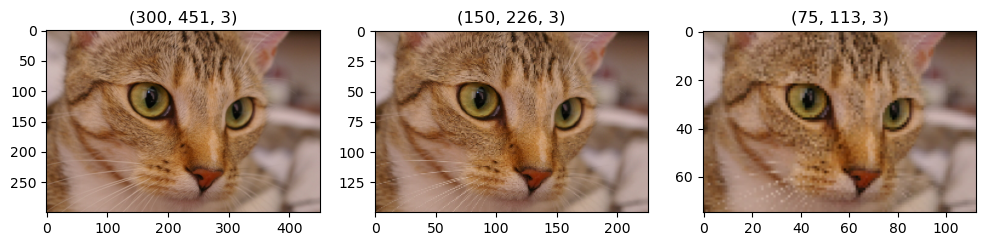

In [22]:
import skimage
img = skimage.data.cat()

plt.figure(figsize=(12,6))

# Original
plt.subplot(131)
plt.imshow(img)
plt.title(img.shape)

# Take every 2nd pixel; 0, 2, 4....
img1 = img[::2,::2, :]
plt.subplot(132)
plt.imshow(img1)
plt.title(img1.shape)

# Take every 4th pixel; 0, 4, 8....
img2 = img[::4,::4, :]
plt.subplot(133)
plt.imshow(img2)
plt.title(img2.shape)


plt.show()

## Application of 2D Convolution

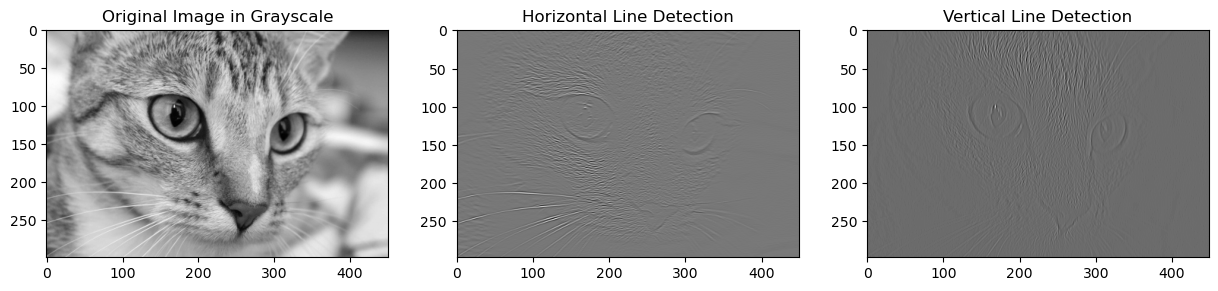

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.data
import skimage.color

# Load the image
original_image = skimage.data.cat()

# Convert the image to grayscale
gray_image = skimage.color.rgb2gray(original_image)

# Display the grayscale image
plt.figure(figsize=(5*3,5))

plt.subplot(131)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image in Grayscale')
# plt.show()


def apply_kernel(image, kernel, bias=0):
    # Copy image to avoid pass by ref.
    image = image.copy()
    
    # Size of the matrices
    image_size = image.shape[0]
    kernel_size = kernel.shape[0]

    # Prepare the output matrix
    output_h = img.shape[0] - kernel_size + 1
    output_w = img.shape[1] - kernel_size + 1
    output = np.zeros((output_h, output_w))

    # Applying the convolution operation
    for i in range(output_h):
        for j in range(output_w):
            # Extract the region of the image to apply the kernel
            region = image[i:(i + kernel_size), j:(j + kernel_size)]
            
            # Apply the kernel and add the result to the output matrix
            output[i, j] = np.sum(region * kernel) + bias
            
    return output

# Horizontal

# Define a simple 3x3 edge detection kernel
kernel = np.array([
    [-1, -1, -1],
    [ 2,  2,  2],
    [-1, -1, -1]
])

# Apply the kernel
filtered_image = apply_kernel(gray_image, kernel)

# Display the filtered image
plt.subplot(132)
plt.imshow(filtered_image, cmap='gray')
plt.title('Horizontal Line Detection')


# Vertical

# Define a simple 3x3 edge detection kernel
kernel = np.array([
    [-1, 2, -1],
    [-1, 2, -1],
    [-1, 2, -1]
])

# Apply the kernel
filtered_image = apply_kernel(gray_image, kernel)

# Display the filtered image
plt.subplot(133)
plt.imshow(filtered_image, cmap='gray')
plt.title('Vertical Line Detection')

plt.show()

## Different 2D Convolutions

### Input Channels: 1 | Number of Filters: 1

| Animation | Input Size | Output Size | Kernel Size | Dilation Rate | Stride | Padding |
|:-----------:|:------------:|:-------------:|:-------------:|:---------------:|:--------:|:---------:|
| <img src="https://maucher.home.hdm-stuttgart.de/Pics/gif/no_padding_no_strides.gif" width="300"> | (4,4) | (2,2) | (3,3) | (1,1) | (1,1) | (0,0) |
| <img src="https://maucher.home.hdm-stuttgart.de/Pics/gif/same_padding_no_strides.gif" width="300"> | (5,5) | (5,5) | (3,3) | (1,1) | (1,1) | (1,1) |
| <img src="https://maucher.home.hdm-stuttgart.de/Pics/gif/no_padding_strides.gif" width="300"> | (5,5) | (2,2) | (3,3) | (1,1) | (2,2) | (0,0) |
| <img src="https://maucher.home.hdm-stuttgart.de/Pics/gif/padding_strides.gif" width="300"> | (5,5) | (3,3) | (3,3) | (1,1) | (2,2) | (1,1) |
| <img src="https://upload.wikimedia.org/wikipedia/commons/c/c1/Convolution_arithmetic_-_Dilation.gif?20190413174621" width="300"> | (7,7) | (3,3) | (3,3) | (2,2) | (1,1) | (0,0) |



### Input Channels: >1 | Number of Filters: 1

* Kernal Size: $(k, k)$ | Input Channel/Filter: $C_i$ | Weights: $(k, k, C_i)$.

<img src="https://miro.medium.com/v2/resize:fit:738/0*4tHPDjvQXX9obrhK.gif" width="400">



### Input Channels: >1 | Number of Filters: >1

* Kernal Size: $(k, k)$ | Input Channel/Filter: $C_i$ | Output Channel/Filter: $C_o$ | Weights: $(k, k, C_i, C_o)$.
* Input Shape: $(H_i, W_i, C_i)$ | Output Shape: $(H_o, W_o, C_o)$


<img src="https://cdn-media-1.freecodecamp.org/images/gb08-2i83P5wPzs3SL-vosNb6Iur5kb5ZH43" width="600">

## Understanding 2D Convolution in Keras

In real-life applications, we often use the `tf.keras.layers.Conv2D` function from Keras to perform 2D convolutions. However, TensorFlow also offers the `tf.nn.conv2d` function which provides a more flexible, albeit lower-level, approach to convolution operations. You can find more details on TensorFlow's official documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d).


> **Note**: In TensorFlow/Keras you can't do customized padding unlike PyTorch. Thus you need apply padding seperately.

> **Note**: For padding in keras, Either the string "SAME" or "VALID" indicating the type of padding algorithm to use, or a list indicating the explicit paddings at the start and end of each dimension. When explicit padding is used and data_format is "NHWC", this should be in the form `[[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]]`. When explicit padding used and data_format is "NCHW", this should be in the form `[[0, 0], [0, 0], [pad_top, pad_bottom], [pad_left, pad_right]]`. 


In [24]:
import tensorflow as tf

# The inputs are 28x28 RGB images with `channels_last` and the batch
# size is 4.
input_shape = (4, 28, 28, 1)
x = tf.random.normal(input_shape)
layer = tf.keras.layers.Conv2D(filters=4,
                       kernel_size=(3,3),
                       strides=(1, 1),
                       padding='valid',
                       dilation_rate=(1, 1),
                       activation=None,
                       use_bias=True,)
y = layer(x)
print(y.shape)

(4, 26, 26, 4)


In [25]:
print('# Weights:',layer.weights)
print('# Biases:',layer.bias)

# Weights: [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 4) dtype=float32, numpy=
array([[[[-0.3370507 ,  0.21175075,  0.22715586, -0.2374297 ]],

        [[-0.10543239, -0.11443979, -0.09322056, -0.2249541 ]],

        [[-0.34451663, -0.03334329,  0.2758147 , -0.05984387]]],


       [[[ 0.21936458,  0.28089833, -0.18716145,  0.16032135]],

        [[-0.26672938,  0.09381595,  0.20574045, -0.18689923]],

        [[-0.21959393,  0.00958318, -0.16520818,  0.34259415]]],


       [[[-0.31823072, -0.02399367, -0.2571866 , -0.34291345]],

        [[ 0.01746786, -0.33779714, -0.31525254,  0.24974698]],

        [[ 0.05726007, -0.06984982,  0.36239743,  0.26012653]]]],
      dtype=float32)>, <tf.Variable 'conv2d/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]
# Biases: <tf.Variable 'conv2d/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>


In [26]:
layer.get_weights()

[array([[[[-0.3370507 ,  0.21175075,  0.22715586, -0.2374297 ]],
 
         [[-0.10543239, -0.11443979, -0.09322056, -0.2249541 ]],
 
         [[-0.34451663, -0.03334329,  0.2758147 , -0.05984387]]],
 
 
        [[[ 0.21936458,  0.28089833, -0.18716145,  0.16032135]],
 
         [[-0.26672938,  0.09381595,  0.20574045, -0.18689923]],
 
         [[-0.21959393,  0.00958318, -0.16520818,  0.34259415]]],
 
 
        [[[-0.31823072, -0.02399367, -0.2571866 , -0.34291345]],
 
         [[ 0.01746786, -0.33779714, -0.31525254,  0.24974698]],
 
         [[ 0.05726007, -0.06984982,  0.36239743,  0.26012653]]]],
       dtype=float32),
 array([0., 0., 0., 0.], dtype=float32)]

In [27]:
layer.set_weights(layer.get_weights())

# CNN Vs DNN

Absolutely, here's a markdown table that summarizes the key differences:

| Aspect                     | Convolutional Neural Networks (CNNs) | Fully Connected Networks (FCNs) |
|----------------------------|--------------------------------------|---------------------------------|
| **Parameter Sharing**      | CNNs share parameters as the same filters are used across different input positions. This reduces computational cost and makes them translationally invariant. | FCNs do not share parameters. Each connection has a unique weight, which can increase the number of parameters and risk of overfitting. |
| **Connectivity**           | CNNs are locally connected, meaning a neuron is connected only to a small region in the previous layer. This reduces parameters and helps recognize spatial patterns. | FCNs are fully connected. Every neuron in a layer is connected to all neurons in the preceding and following layers. This may lead to increased model complexity and overfitting. |
| **Translational Invariance** | CNNs, due to parameter sharing and filter application across the image, can recognize patterns regardless of their position in the image. | Traditional FCNs do not possess translational invariance. They treat input features independently and may not recognize spatial patterns as efficiently as CNNs. |

Here's a visual insight about their connectivity,

<img src="https://i.ibb.co/PgF0cZQ/cnn-fcn.jpg" width="600">

## Computational Cost and Parameter Comparision

### CNN

* Kernal Size: $(k, k)$ | Input Channel/Filter: $C_i$ | Output Channel/Filter: $C_o$ | Weights: $(k, k, C_i, C_o)$.
* Input Shape: $(B, H_i, W_i, C_i)$ | Output Shape: $(B, H_o, W_o, C_o)$
* The computational cost $C_{cnn}$ can be written as:

$$
C_{cnn} = B \times H_o \times W_o \times C_o \times k \times k \times C_i\\
P_{cnn} = k^2 \times C_i \times C_o + C_o
$$

### FCN
* Input Channel/Filter: $F_i$ | Output Channel/Filter: $F_o$ | Weights: $(F_i, F_o)$.
* Input Shape: $(B, F_i)$ | Output Shape: $(B, F_o)$
* The computational cost $C_{fcn}$ can be written in LaTex as:

$$
C_{fcn} = B \times F_i \times F_o\\
P_{fcn} = F_i \times F_o + F_o
$$




# Pooling Layer

## What is Pooling Layer?

A pooling layer is a layer in a CNN that downsamples the feature maps from the previous convolutional layer, reducing their size and making them more robust to variations in the input image.

## Why it is used?

Pooling layers are used to:

- Reduce the memory and computational requirements of the network.
- Reduce the number of parameters and the risk of overfitting.
- Introduce local translation invariance, which means small changes in the location of the features do not affect the output.

## How it works?

Pooling layers work by sliding a filter over each channel of the feature map and summarizing the features within the filter region. There are different types of pooling layers, such as average pooling, max pooling, and global pooling. Each type has a different way of summarizing the features:

- Average pooling computes the average of the elements in the filter region.
- Max pooling selects the maximum element in the filter region.
- Global pooling reduces each channel to a single value.

<img src="https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif">

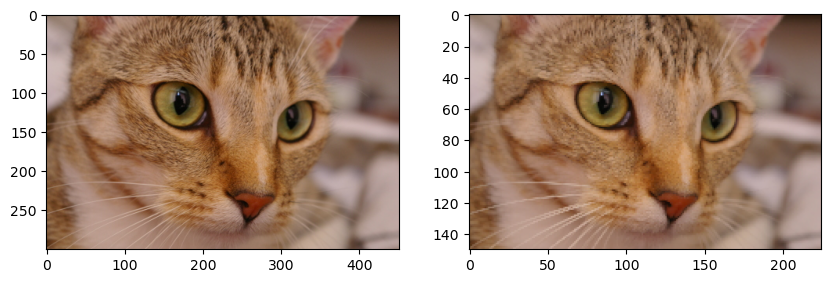

In [28]:
image = skimage.data.cat()

layer = tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), # window size
    strides=None, # if None same as pool_size
    padding='valid')
out = layer(image[None,])[0,]


plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image)

plt.subplot(122)
plt.imshow(out)

plt.show()

# CNN Model

<img src="https://www.mobiquity.com/hs-fs/hubfs/CNN03.gif?width=960&name=CNN03.gif" width=700>

In [29]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

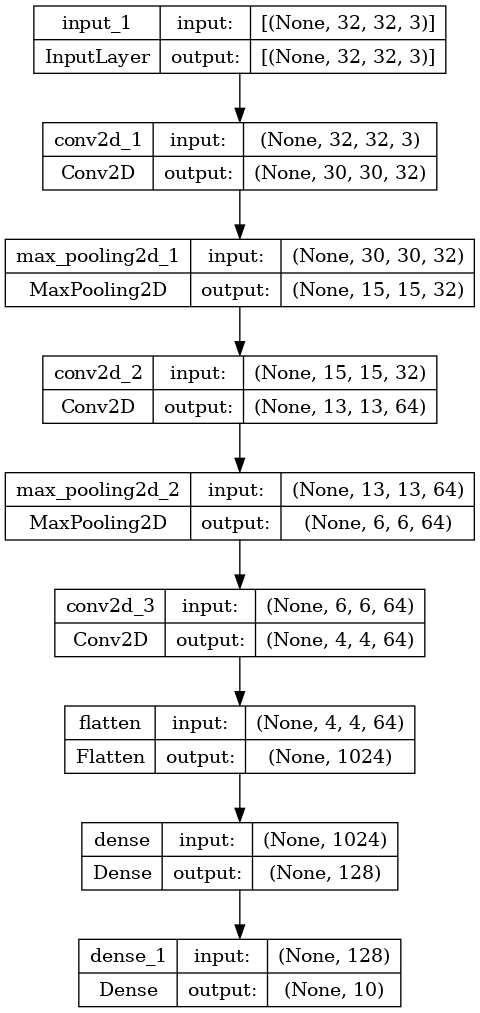

In [30]:
model = build_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

## Check Feed Forward

In [31]:
out = model(imgs)
out.shape

TensorShape([16, 10])

## Store and Load Model

* **Keras model** includes everything about the model, its architecture (how layers are organized), the learning process setup (the optimizer and loss function), and the learned parameters (weights and biases).

* **Keras model weights** are just the learned parameters of the model. They are the values adjusted through the training process to improve the model's performance, but without the context of the model architecture or how they were learned (optimizer), they're not very useful.


> **Caution**: don't try to load weights using `tf.keras.models.load_model` otherwise it'll throw error. 

In [32]:
# Save model
model.save('tmp_model.h5')

# Load model
model = tf.keras.models.load_model('tmp_model.h5')


# Save weights
model.save_weights('tmp_weights.h5')

# Load weights
model = model.load_weights('tmp_weights.h5')

# No Augmentation


## Training
Now let's train a **CNN** model in other words, "চলো দেখতে শিখাই" 👶. 


In [33]:
# Step 1: Get train-test image paths and labels
train_paths = train_df['image_path'].tolist()
train_labels = train_df['class_label'].tolist()

valid_paths = valid_df['image_path'].tolist()
valid_labels = valid_df['class_label'].tolist()

# Step 2: Data loader
train_loader = DataLoader(train_paths, train_labels, batch_size=128)

valid_loader = DataLoader(valid_paths, valid_labels, batch_size=128, shuffle=False)


# Step 3: Build the model
model = build_model()

# Step 4: Model training
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/best_ckpt.h5',
                                             monitor = 'val_accuracy',
                                             verbose = 0,
                                             save_best_only = True,
                                             save_weights_only = False,
                                             mode = 'max') # to save best scoring model

print('## Training')
history = model.fit(train_loader,
                    validation_data=valid_loader,
                    epochs=25,
                    verbose=1,
                    callbacks=[ckpt_cb])

# Step 5: Predict on test data

## Load best model
model = tf.keras.models.load_model('/kaggle/working/best_ckpt.h5')

print("\n## Inference")
valid_loader = DataLoader(valid_paths, valid_labels, batch_size=100, shuffle=False)
predictions = model.predict(valid_loader)

# Step 6: Measure performance
acc = accuracy_score(valid_labels, predictions.argmax(-1))
print(f"\n## Accuracy: {acc}")

## Training
Epoch 1/25
137/137 [==============================] - 149s 1s/step - loss: 1.9098 - accuracy: 0.2990 - val_loss: 1.6512 - val_accuracy: 0.4021
Epoch 2/25
137/137 [==============================] - 24s 176ms/step - loss: 1.5712 - accuracy: 0.4264 - val_loss: 1.4627 - val_accuracy: 0.4662
Epoch 3/25
137/137 [==============================] - 26s 187ms/step - loss: 1.4453 - accuracy: 0.4833 - val_loss: 1.4160 - val_accuracy: 0.4869
Epoch 4/25
137/137 [==============================] - 24s 176ms/step - loss: 1.3523 - accuracy: 0.5174 - val_loss: 1.3599 - val_accuracy: 0.5081
Epoch 5/25
137/137 [==============================] - 25s 179ms/step - loss: 1.2774 - accuracy: 0.5459 - val_loss: 1.2578 - val_accuracy: 0.5471
Epoch 6/25
137/137 [==============================] - 24s 178ms/step - loss: 1.2043 - accuracy: 0.5729 - val_loss: 1.2635 - val_accuracy: 0.5580
Epoch 7/25
137/137 [==============================] - 24s 172ms/step - loss: 1.1408 - accuracy: 0.5957 - val_loss: 1.164

## History

In [34]:
history.history

{'loss': [1.9097568988800049,
  1.5711984634399414,
  1.4452948570251465,
  1.352273941040039,
  1.2773520946502686,
  1.2043312788009644,
  1.1407642364501953,
  1.091541051864624,
  1.0456249713897705,
  0.9930749535560608,
  0.9351978302001953,
  0.8955065608024597,
  0.8571059703826904,
  0.8058140277862549,
  0.764228880405426,
  0.7333898544311523,
  0.6936379671096802,
  0.667987585067749,
  0.6337206959724426,
  0.5971606373786926,
  0.5579591393470764,
  0.5234869122505188,
  0.48826104402542114,
  0.46262219548225403,
  0.4253103733062744],
 'accuracy': [0.29898494482040405,
  0.42643705010414124,
  0.483348548412323,
  0.5173928141593933,
  0.545905590057373,
  0.5729357004165649,
  0.5956888794898987,
  0.6159329414367676,
  0.633838951587677,
  0.6510036587715149,
  0.6703923344612122,
  0.6856181621551514,
  0.702041506767273,
  0.7173813581466675,
  0.7360857725143433,
  0.744240403175354,
  0.7584968209266663,
  0.7669366002082825,
  0.7779425382614136,
  0.792427003383

## Plot History

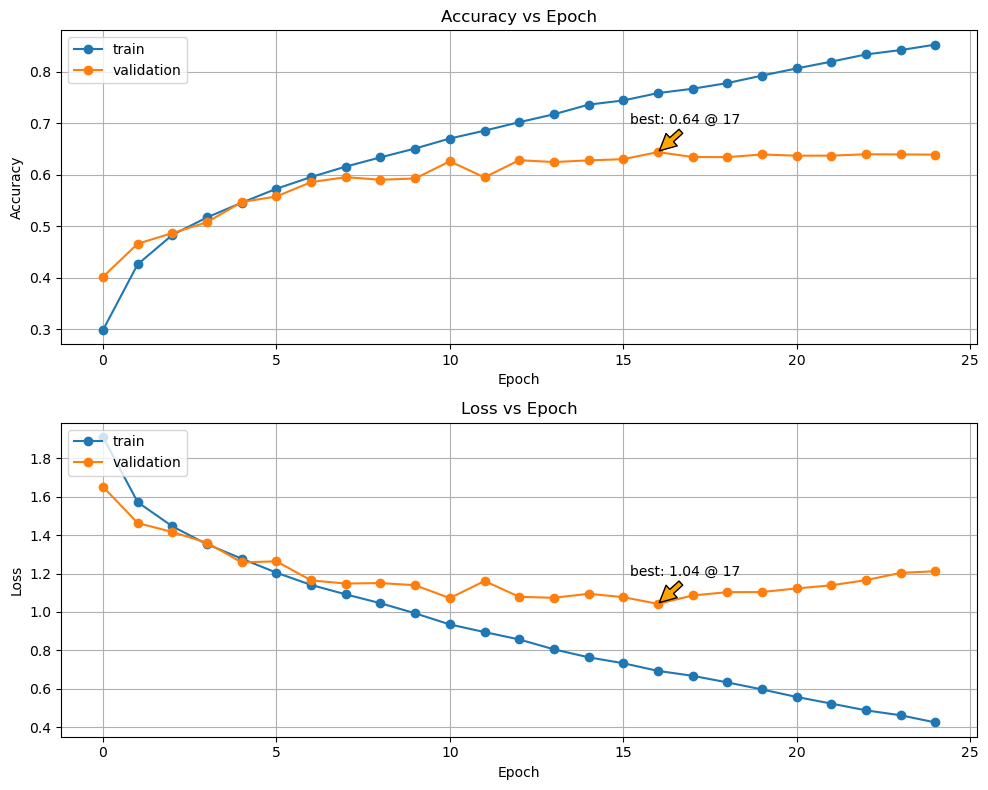

In [35]:
import matplotlib.pyplot as plt

def plot_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], '-o')
    plt.plot(history.history['val_accuracy'], '-o')
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    # Get the epoch at which the validation accuracy is max
    best_val_acc = max(history.history['val_accuracy'])
    best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc)
    plt.annotate(f'best: {best_val_acc:.2f} @ {best_val_acc_epoch+1}',
                 xy=(best_val_acc_epoch, best_val_acc),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10,
                 color='black')

    # summarize history for loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], '-o')
    plt.plot(history.history['val_loss'], '-o')
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    # Get the epoch at which the validation loss is min
    best_val_loss_epoch = best_val_acc_epoch
    best_val_loss = history.history['val_loss'][best_val_loss_epoch]
    plt.annotate(f'best: {best_val_loss:.2f} @ {best_val_loss_epoch+1}',
                 xy=(best_val_loss_epoch, best_val_loss),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10,
                 color='black')

    plt.tight_layout()
    plt.show()
    
# Plot history of training
plot_history(history)

## Result Analysis

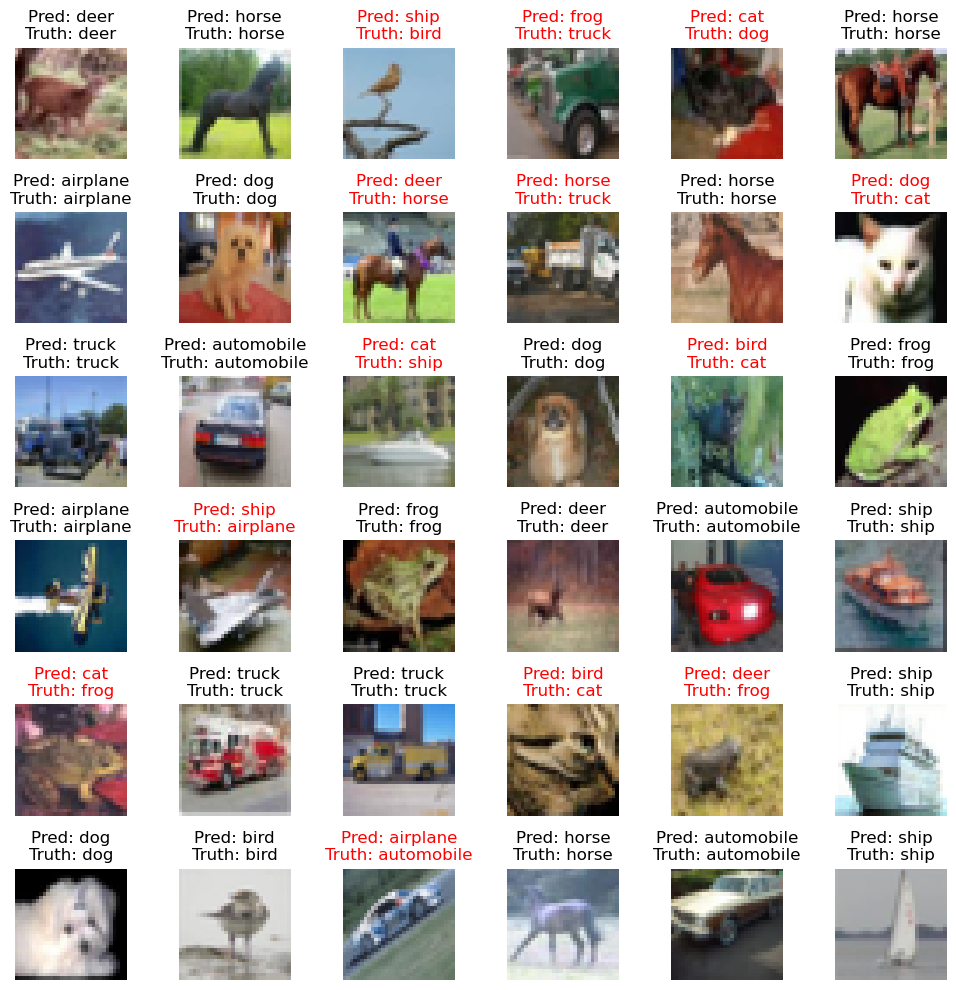

In [36]:
import numpy as np
import matplotlib.pyplot as plt

num_images = 36
sqrt_num_images = int(np.sqrt(num_images))
indices = np.random.choice(len(valid_paths), num_images, replace=False)
fig, axes = plt.subplots(nrows=sqrt_num_images, ncols=sqrt_num_images, figsize=(10, 10))

for i, idx in enumerate(indices):
    row = i // sqrt_num_images
    col = i % sqrt_num_images

    image_path = valid_paths[idx]
    image = load_image(image_path)  # Load and preprocess single image
    
    # Get prediction and ground truth
    pred = np.argmax(predictions[idx], axis=-1)
    pred = label2name[pred] # 0 -> cat
    true = valid_labels[idx]
    true = label2name[true] # 0 -> cat

    axes[row, col].imshow(image)
    axes[row, col].axis('off')

    if pred == true:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}')
    else:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}', color='red')

plt.tight_layout()
plt.show()


## Inference

In [37]:
test_loader = DataLoader(test_paths, labels=None, batch_size=200, shuffle=False)
test_preds = model.predict(test_loader)


sub_df = test_df[['id']].copy()

sub_df['label'] = test_preds.argmax(axis=-1)
sub_df['label'] = sub_df.label.map(label2name) # 0 -> cat

sub_df = sub_df[['id','label']]

sub_df.to_csv('submission.csv',index=False)

sub_df.head()

50/50 [==============================] - 59s 1s/step


,id,label
0,01301.png,bird
1,02578.png,bird
2,06781.png,frog
3,00929.png,airplane
4,04915.png,deer


# Augmentation

Image augmentation is like changing the perspective of a photo — flipping it, rotating it, zooming in, moving it around, or changing lighting conditions — to create new versions of that image. It's used in machine learning to prevent **overfitting** and help models generalize better. For instance, if you train a model to recognize cats but all your photos are of cats directly facing the camera in good lighting, it might not recognize a cat seen from the side or in dim light.

<p float="left">
  <img src="https://camo.githubusercontent.com/3bb6e4bb500d96ad7bb4e4047af22a63ddf3242a894adf55ebffd3e184e4d113/68747470733a2f2f686162726173746f726167652e6f72672f776562742f62642f6e652f72762f62646e6572763563746b75646d73617a6e687734637273646669772e6a706567" width="500" />
  <img src="https://camo.githubusercontent.com/760ccb0f1b5a4d118417aec881315a5c3a6ff2803ec7ab4b32cbb1998881c8c3/68747470733a2f2f686162726173746f726167652e6f72672f776562742f652d2f366b2f7a2d2f652d366b7a2d66756770326865616b336a7a6e733362632d72386f2e6a706567" width="500" /> 
</p>

> **Overfitting** happens when a model learns too much from the training data, including noise and outliers, and performs poorly on new data. It's like studying so hard for an exam that you remember all the textbook word by word, but can't apply the concepts to different types of questions.

> **Underfitting** occurs when a model can't learn enough from the training data and performs poorly even on that data. It's like studying for an exam but only grasping the basics and not understanding the complex parts.


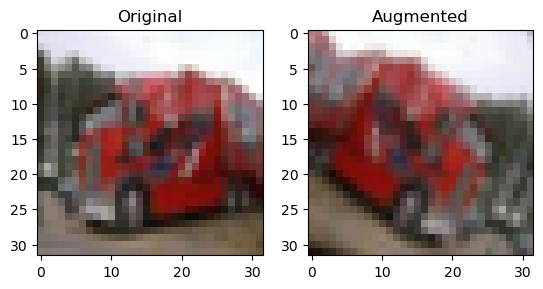

In [38]:
import albumentations as A
augment = A.Compose([A.HorizontalFlip(p=0.5),
                     A.RandomBrightnessContrast(p=0.5),
                     A.Rotate(limit=30, p=0.5)])

plt.subplot(121)
plt.imshow(imgs[0])
plt.title('Original')

plt.subplot(122)
aug_img = augment(image=imgs[0])["image"]
plt.imshow(aug_img)
plt.title('Augmented')

plt.show();

## Visualization

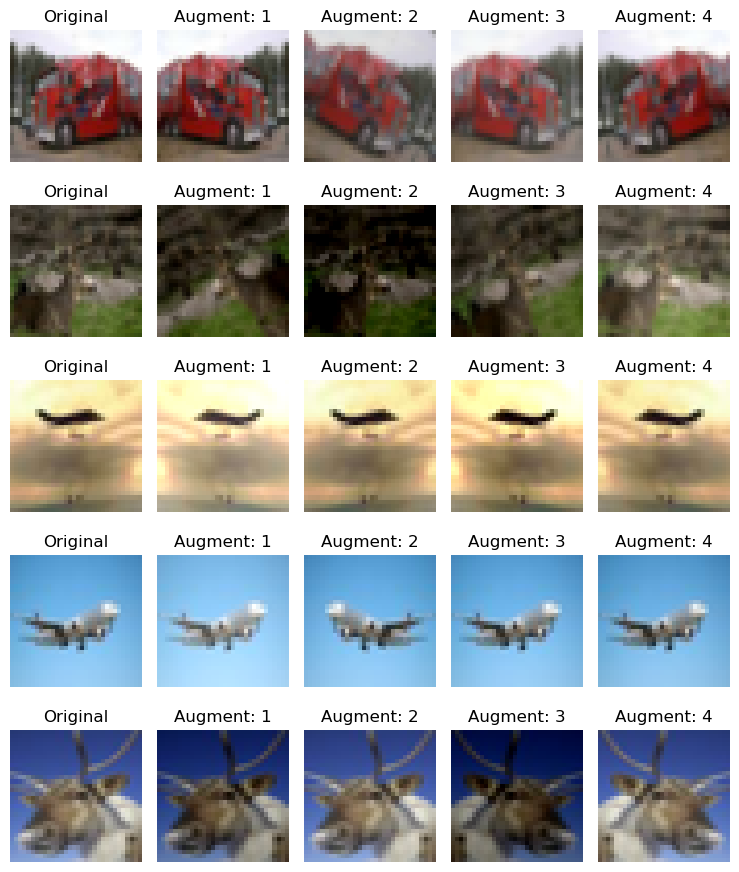

In [39]:
plt.figure(figsize=(5*1.5, 6*1.5))
nrow = 5; ncol = 5;
for i in range(5):
    img = imgs[i]
    plt.subplot(nrow, ncol, i*ncol + 0 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original')
    for j in range(1, 5):
        plt.subplot(nrow, ncol, i*ncol + j + 1)
        aug_img = augment(image=img)["image"]
        plt.imshow(aug_img)
        plt.axis('off')
        plt.title(f'Augment: {j}')
        
plt.tight_layout()
plt.show()

## Updated Dataloader
Add augmentation in the dataloader.

In [40]:
class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, paths, labels=None, batch_size=32, num_classes=10,
                 dim=(32, 32), shuffle=True,
                 augment=True, augment_fn=None):
        """Initialization method for the DataLoader class."""
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.dim = dim
        self.shuffle = shuffle
        
        # For augmentation
        self.augment = augment
        self.augment_fn = augment_fn
        if self.augment and self.augment_fn is None:
            self.augment_fn = A.Compose([A.HorizontalFlip(p=0.5),
                                         A.RandomBrightnessContrast(p=0.5),
                                         A.Rotate(limit=30, p=0.5)])
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        batch = self.__data_generation(batch_indexes)

        return batch

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        """Generates data containing batch_size samples."""
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3))
        if self.labels is not None:
            y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, idx in enumerate(batch_indexes):
            # Load sample
            img = load_image(self.paths[idx])
            
            # Apply augmentation
            if self.augment:
                img = self.augment_fn(image=img)["image"]
                
            # Store Sample
            X[i,] = img

            # Store class
            if self.labels is not None:
                y[i] = self.labels[idx]

        # Flatten the image pixels for Dense layer
#         X = X.reshape(self.batch_size, -1)  # shape: (32, 28, 28) => (32, 28*28) => (32, 784)

        # Do scaling, range: [0, 255] => [0, 1]
        X = X / 255.0

        # Apply one-hot encoding to labels [0, 1, 2] => [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
        if self.labels is not None:
            y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
            return X, y
        
        # if there is labels = None, then only return X
        return X

## Updated Model

**Dropout** in Keras is a technique that helps prevent overfitting in neural networks by randomly setting a fraction of input units to 0 at each update during training time.

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif" width="600">

We need it to ensure our model generalizes well and doesn't rely too heavily on any single input, making it more robust to unseen data.

Example usage in Keras:

```python
tf.keras.layers.Dropout(rate=0.5)
```
Here, 0.5 represents the fraction of input units to drop, in this case, 50%.

In [41]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.10),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Callbacks

**Callbacks** are tools that allow you to customize and control the behavior of a model during training, evaluation, or inference. 

**Why use them?**
They enable automatic actions during training, like saving the model, adjusting learning rates, or stopping training when certain conditions are met.

**How do they work?**
Callbacks are Python classes that implement specific methods to be executed at different stages of training (e.g., at the start or end of an epoch). For instance, a callback can be created to stop training when the accuracy exceeds 90%:

```python
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.90:
            self.model.stop_training = True

model.fit(X_train, y_train, epochs=10, callbacks=[MyCallback()])
```
To learn more about custom callbacks you can check out this [this](https://www.tensorflow.org/guide/keras/writing_your_own_callbacks) and to learn about existing callbacks check out [this](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks?).

> In out notebook we'll use checkpoint callback which will store the best scoring model in disk.

## Training

In [42]:
# Step 1: Get train-test image paths and labels
train_paths = train_df['image_path'].tolist()
train_labels = train_df['class_label'].tolist()

valid_paths = valid_df['image_path'].tolist()
valid_labels = valid_df['class_label'].tolist()

# Step 2: Data loader
train_loader = DataLoader(train_paths, train_labels, batch_size=128)

valid_loader = DataLoader(valid_paths, valid_labels, batch_size=128, shuffle=False, augment=False)


# Step 3: Build the model
model = build_model()

# Step 4: Model training
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/best_aug_ckpt.h5',
                                             monitor = 'val_accuracy',
                                             verbose = 0,
                                             save_best_only = True,
                                             save_weights_only = False,
                                             mode = 'max') # to save best scoring model

print('## Training')
history = model.fit(train_loader,
                    validation_data=valid_loader,
                    epochs=25,
                    verbose=1,
                    callbacks=[ckpt_cb])

# Step 5: Predict on test data

## Load best model
model = tf.keras.models.load_model('/kaggle/working/best_aug_ckpt.h5') # you can save model using model.save()

print("\n## Inference")
valid_loader = DataLoader(valid_paths, valid_labels, batch_size=100, shuffle=False, augment=False)
predictions = model.predict(valid_loader)

# Step 6: Measure performance
acc = accuracy_score(valid_labels, predictions.argmax(-1))
print(f"\n## Accuracy: {acc}")

## Training
Epoch 1/25
137/137 [==============================] - 34s 233ms/step - loss: 1.9632 - accuracy: 0.2717 - val_loss: 1.6488 - val_accuracy: 0.4041
Epoch 2/25
137/137 [==============================] - 26s 193ms/step - loss: 1.6409 - accuracy: 0.3997 - val_loss: 1.5210 - val_accuracy: 0.4562
Epoch 3/25
137/137 [==============================] - 27s 197ms/step - loss: 1.5077 - accuracy: 0.4581 - val_loss: 1.4848 - val_accuracy: 0.4559
Epoch 4/25
137/137 [==============================] - 29s 215ms/step - loss: 1.4197 - accuracy: 0.4905 - val_loss: 1.3078 - val_accuracy: 0.5347
Epoch 5/25
137/137 [==============================] - 28s 206ms/step - loss: 1.3643 - accuracy: 0.5105 - val_loss: 1.2879 - val_accuracy: 0.5409
Epoch 6/25
137/137 [==============================] - 27s 197ms/step - loss: 1.3077 - accuracy: 0.5330 - val_loss: 1.2359 - val_accuracy: 0.5673
Epoch 7/25
137/137 [==============================] - 27s 198ms/step - loss: 1.2723 - accuracy: 0.5459 - val_loss: 1.1

## Plot History

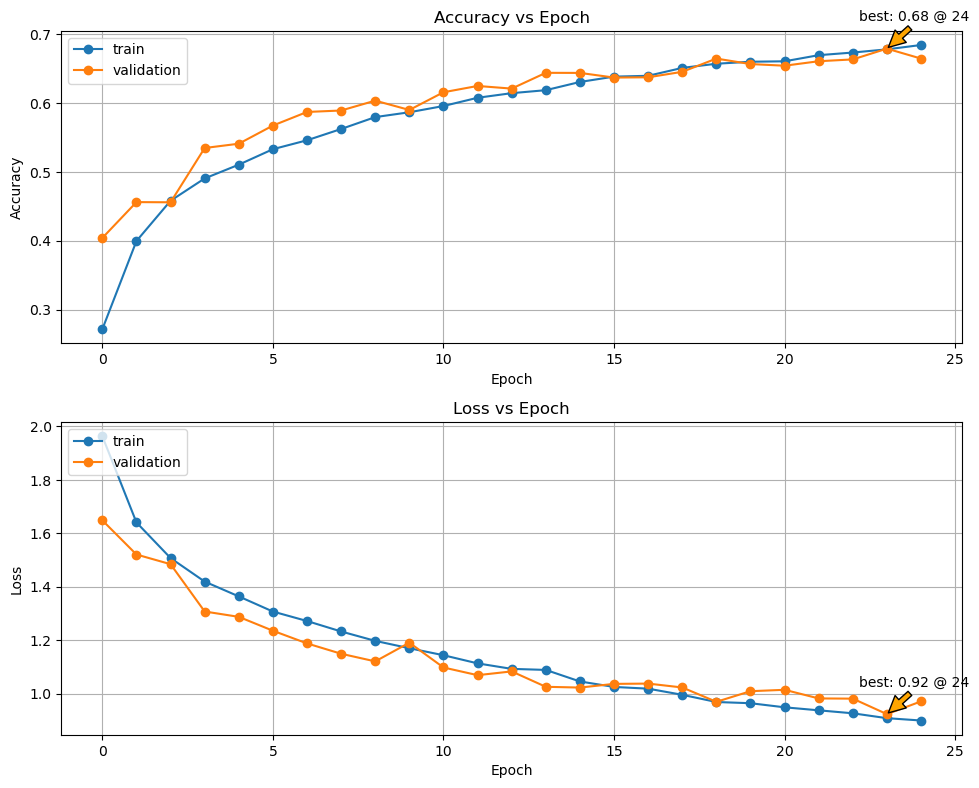

In [43]:
# After training, call the plot function
plot_history(history)

## Result Analysis

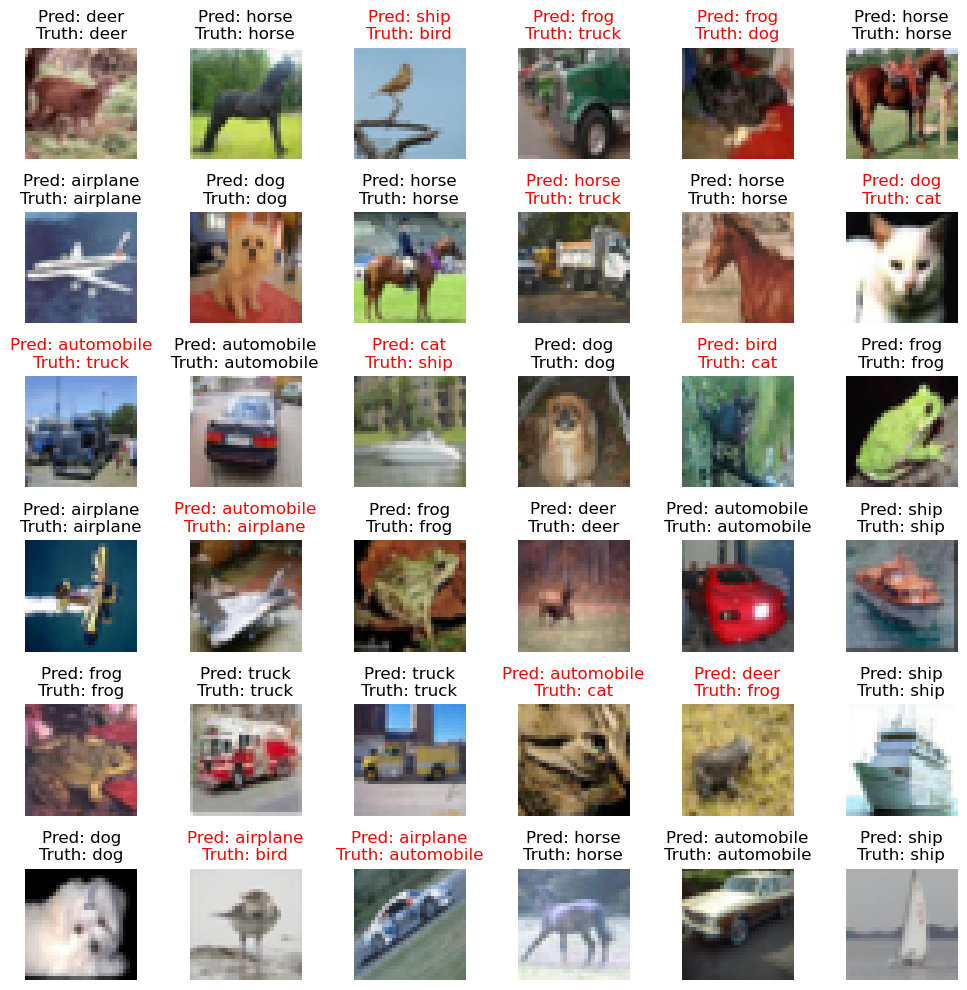

In [44]:
import numpy as np
import matplotlib.pyplot as plt

num_images = 36
sqrt_num_images = int(np.sqrt(num_images))
# indices = np.random.choice(len(valid_paths), num_images, replace=False)
fig, axes = plt.subplots(nrows=sqrt_num_images, ncols=sqrt_num_images, figsize=(10, 10))

for i, idx in enumerate(indices):
    row = i // sqrt_num_images
    col = i % sqrt_num_images

    image_path = valid_paths[idx]
    image = load_image(image_path)  # Load and preprocess single image
    
    # Get prediction and ground truth
    pred = np.argmax(predictions[idx], axis=-1)
    pred = label2name[pred] # 0 -> cat
    true = valid_labels[idx]
    true = label2name[true] # 0 -> cat

    axes[row, col].imshow(image)
    axes[row, col].axis('off')

    if pred == true:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}')
    else:
        axes[row, col].set_title(f'Pred: {pred}\nTruth: {true}', color='red')

plt.tight_layout()
plt.show()


## Inference

In [45]:
test_loader = DataLoader(test_paths, labels=None, batch_size=200, shuffle=False, augment=False)
test_preds = model.predict(test_loader)


sub_df = test_df[['id']].copy()

sub_df['label'] = test_preds.argmax(axis=-1)
sub_df['label'] = sub_df.label.map(label2name) # 0 -> cat

sub_df = sub_df[['id','label']]

sub_df.to_csv('submission_aug.csv',index=False)

sub_df.head()

50/50 [==============================] - 14s 275ms/step


,id,label
0,01301.png,airplane
1,02578.png,bird
2,06781.png,cat
3,00929.png,airplane
4,04915.png,horse
